<a href="https://colab.research.google.com/github/RafaelVendiciano/Portfolio/blob/master/Churn_Prediction_Para_Uma_Empresa_de_Telecomunica%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Churn Prediction

*Churn rate*, ou simplesmente *churn*, representa a taxa de evasão da sua base de clientes. Em serviços como Spotify ou Netflix, ela representaria a taxa de cancelamento de assinaturas.

<p align=center>
<img src="https://raw.githubusercontent.com/carlosfab/dsnp2/master/img/churnrate.jpg" width="60%"></p>

Ela é de extrema importância para a administração e sua análise ao longo do tempo pode mostrar que existe algum problema que deve ser atacado.

*Churn* também pode ser usado para identificar potenciais cancelamentos, com um tempo de antecedência, e promover ações direcionadas para tentar reter tais clientes. Essa métrica deve receber atenção pelo fato de que o Custo de Aquisição de Cliente (CAC) é normalmente mais alto que o custo para mantê-los. Ou seja, um alto valor para o *churn rate* é o que não desejamos.

## Aquisição dos Dados

Os dados utilizados neste projeto foram originalmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíves, os nomes das colunas permitem um entendimento a respeito do problema.

In [1]:
# importar os pacotes necessários
!pip install scikit-plot -q
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
pd.set_option('display.max_rows', 1000)
np.random.seed(42)
 
%matplotlib inline

# importar os dados
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


##Análise Exploratória dos Dados

A fim de começar este projeto, irei verificar a integridade e usabilidade do dataset.

Para isso, deixarei  abaixo informações como: Número de linhas e colunas, quais são as variáveis do banco de dados, a quantidade de valores ausentes e o número de valores únicos por coluna. Essa última, especificamente, vai auxiliar na identificação de variáveis potencialmente categóricas.

**Primeiras e últimas 5 linhas do Dataset**

In [2]:
# Primeiras 5 entradas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Ultimas 5 entradas
df.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


**Número de linhas e colunas e quais são as variáveis do banco de dados**

In [4]:
# Informações sobre o Dataset
print('Número de linhas: {}'.format(df.shape[0]))
print('Número de colunas: {}\n'.format(df.shape[1]))
print('Colunas: \n{}'.format(df.dtypes))

Número de linhas: 7043
Número de colunas: 21

Colunas: 
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


**Quantidade de valores ausentes e de valores únicos por coluna**

In [5]:
# Informações sobre o Dataset
print('Quantidade de Valores ausentes: {}\n'.format(df.isnull().sum().values.sum()))
print('Quantidade de valores unicos por coluna: \n{}'.format(df.nunique()))

Quantidade de Valores ausentes: 0

Quantidade de valores unicos por coluna: 
customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


**Algumas informações podem ser tiradas dos dados acima:**
* O banco de dados tem 7043 entradas e 21 variáveis.
* A maioria das colunas tem como tipo da informação: `object`, ou seja, são informações em texto.
* Não há valores ausentes no dataset.
* Apenas 4 colunas tem mais que 4 valores únicos, sendo a maioria com 2 ou 3 valores únicos.

**Além disso, vale ressaltar alguns pontos:**
* A coluna costumerID não agrega nenhuma informação, pois se trata de um identificador única para cada cliente.
* A variável alvo está na coluna Churn, indicando a situação de churn.
* A coluna TotalCharges deveria ser um float, mas está como string.
 * Como iremos ver mais à frente, apesar de não termos detectado nenhum valor ausente, existem algumas strings que representam sim valores ausentes.
* Várias features precisam ser codificadas para valores numéricos.
* Há várias features binárias, incluindo nossa variável alvo, ou com múltiplos valores, cada um representando uma categoria.

Abaixo, irei apagar a coluna `customerID` e transformar a coluna `Total Charges` em numérica, pois apesar de ser representada com números, está composta de strings.

In [6]:
# Criando função para transformar string em float
def converter_str_float(entrada):
    """
    Converte um objeto do tipo string em float.

    # Inputs:
        string, string da coluna TotalCharges.

    # Returns
        Valor convertido em float, caso permita a conversão.
        NaN, caso o valor não seja apropriado.
    """

    try:
        return float(entrada)
    except ValueError:
        return np.nan

# criar cópia do dataframe
df_clean = df.copy()

# remover coluna costumerID
df_clean.drop("customerID", axis=1, inplace=True)

# converter as strings de TotalCharges para float
df_clean["TotalCharges"] = df_clean["TotalCharges"].apply(converter_str_float)

# verificar entradas ausentes
print("Dados ausentes em 'TotalCharges' (antes):\t{}\n".format(df_clean["TotalCharges"].isnull().sum()))

# substituir os dados ausentes pelo valor da mediana
TotalChargesMedian = df_clean.TotalCharges.median()
df_clean["TotalCharges"].fillna(TotalChargesMedian, inplace=True)

# verificar entradas ausentes novamente
print("Dados ausentes em 'TotalCharges' (depois):\t{}\n".format(df_clean["TotalCharges"].isnull().sum()))

Dados ausentes em 'TotalCharges' (antes):	11

Dados ausentes em 'TotalCharges' (depois):	0



Como podemos ver acima, após transformar em numérica, vimos que a coluna tinha 11 dados ausentes, então substitui esses valores com a mediana dos dados dessa variável.

Apesar deste dataset ser composto majoritariamente por variáveis categóricas, é possível ver abaixo, pelo método `describe`, que não parece haver a presença de outliers.

In [7]:
df_clean.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


Essa constatação de não haver outliers pode ser percebida, por exemplo, nos boxplots de `MonthlyCharges` e `TotalCharges` abaixo. Os gráficos não identificaram pontos além dos limites padrões.

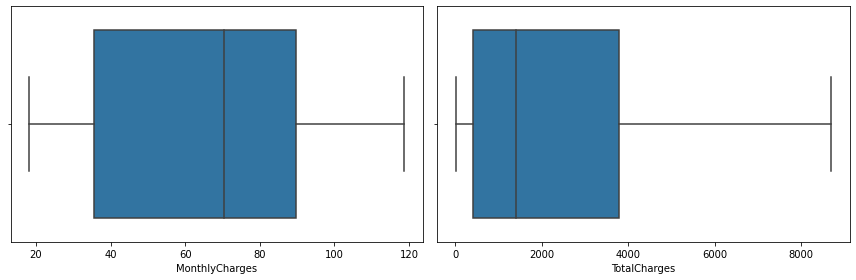

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(df_clean['MonthlyCharges'], ax=ax[0])
sns.boxplot(df_clean['TotalCharges'], ax=ax[1])
plt.tight_layout()

Para identificar se os nossos dados podem estar com algum tipo de viés, irei verificar a contagem de valores para `Male` e `Female`.

Abaixo, você pode ver que o gênero das entradas está balanceado.

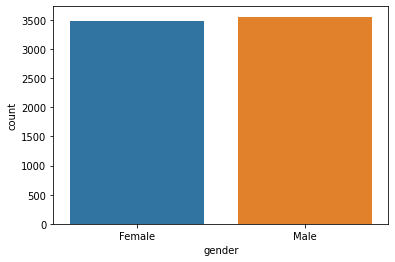

In [9]:
sns.countplot(df_clean.gender)
plt.show()

O caso acima não se repete quando o assunto é Churn, a variável principal da análise é composta majoritariamente de `No`, o que pode ser bom para uma empresa, mas, para treinar o modelo de Machine Learning, vai ser necessário balancear esses dados a fim de se obter um melhor resultado.

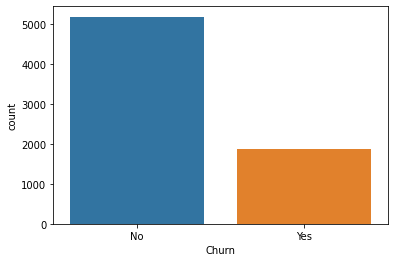

In [10]:
sns.countplot(df_clean.Churn)
plt.show()

## Preparar os Dados

Nesta etapa de preparação dos dados, será realizado um pré-processamento básico, apenas com a finalidade de construir um modelo base.

As features que continham 2 labels únicos, serão processadas usando-se o `LabelEncoder`, para transformar as informações em valores 0 e 1. Vale lembrar que isso inclui a variável alvo `Churn`. Na sequência, serão separadas as variáveis numéricas das categóricas. As categóricas serão transformadas em variáveis dummy, para permitir a sua utilização em todos os modelos.

In [11]:
# pré processar as variáveis
binary_var = df_clean.nunique()[df_clean.nunique() == 2].keys().tolist()
num_var = [col for col in df_clean.select_dtypes(['int', 'float']).columns.tolist() if col not in binary_var]
cat_var = [col for col in df_clean.columns.tolist() if col not in binary_var + num_var]

# criar uma cópia do dataframe
df_proc = df_clean.copy()

# Label Encoding para as variáveis Binárias
le = LabelEncoder()
for i in binary_var:
    df_proc[i] = le.fit_transform(df_proc[i])

# Encoding para colunas categóricas com múltiplas classes
df_proc = pd.get_dummies(df_proc, columns=cat_var)

# ver as 5 primeiras entradas do novo dataframe
df_proc.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


Acima, podemos ver como o Dataset ficou após preparar os dados.

## Machine Learning

Com o processamento realizado na etapa anterior, os dados já podem ser usados nos modelos de machine learning.

Para podermos comparar o desempenho e melhora do modelo, usarei um algoritmo simples. Não será feito nenhum ajuste nos hiperparâmetros e nem será pensado ainda em balanceamento de dados ou feature enginnering.

No entanto, é importante separar os dados que serão utilizados como treino e como teste. Os dados de teste só irão ser usados na última etapa do projeto, para termos uma avaliação mais real.

In [12]:
# separar a feature matrix da target vector
X = df_proc.drop('Churn', axis=1)
y = df_proc['Churn']

# dividir os dados entre treino e teste.
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y)

Agora, irei criar uma função, que dei o nome `val_model`. Essa função, ao dar os inputs X_train, y_train e o modelo de machine learning, ela vai fazer uma validação cruzada, ou seja, vai dividir esses dados de 5 formas diferentes e ver o resultado do modelo com cada uma dessas 5 divisões diferentes.

O objetivo disso é ter uma média da assertividade do modelo com varios dados diferentes, assim, aumentando a nossa confiança com o modelo.

In [13]:
# Criando função para fazer validação cruzada
def val_model(X, y, clf, quite=False):
    """
    Realiza cross-validation com os dados de treino para determinado modelo.

    # Arguments
        X: DataFrame, contém as variáveis independetes.
        y: Series, vetor contendo a variável alvo.
        clf: modelo classificador do Scikit-learn.
        quite: bool, indicando se a função deve imprimir os resultados ou não.

    # Returns
        float, média dos scores da cross-validation.
    """
    
    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='recall')

    if quite == False:
        print("Recall: {:.2f} (+/- {:.2f})".format(scores.mean(), scores.std()))
    
    return scores.mean()

Agora, irei testar a função acima com um modelo de `Random Forest`, sem nenhum tipo de alteração nos parâmetros e sem balancear os dados.

In [14]:
# Testando a função com um Algoritmo de Classificação
rf = RandomForestClassifier()
score_inicial = val_model(X_train, y_train, rf)

Recall: 0.49 (+/- 0.03)


Acima podemos ver que nosso modelo teve uma média de 0.48 de recall, que é uma medida de assertividade.

O recall nos informa uma porcentagem que mede quantos *churn=1* o modelo acertou, de todos os 1 que aconteceram.

Uma vez que temos um baseline para comparar se os ajustes melhoram ou pioram o desempenho do modelo, irei realizar o balanceamento dos dados e ver como isso irá impactar.

A técnica escolhida foi Under Sampling. Seguindo recomendações de algumas literaturas, os dados serão padronizados antes de usar essa técnica de balanceamento.

Lembrando, é importante que o balanceamento aconteca apenas com os dados de treino. Os dados de teste devem permanecer intocáveis.

In [15]:
# Padronizar os Dados
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# Balancear os Dados de Treino
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Agora, aplicarei a validação cruzada com vários modelos para podermos escolher um para seguir o projeto, desta vez, os dados estão balanceados e já vai haver uma mudança significativa em comparação com a nota passada.

Os modelos escolhidos são:
* Random Forest
* Decision Tree
* Stochastic Gradient Descent
* SVC
* Regressão Logística
* XG Boost
* LightGBM

In [16]:
# instanciar modelos
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
sgdc = SGDClassifier()
svc = SVC()
lr = LogisticRegression()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

model = []
recall = []
# avaliar o desempenho (recall)
for clf in (rf, dt, sgdc, svc, lr, xgb, lgbm):
    model.append(clf.__class__.__name__)
    recall.append(val_model(X_train_rus, y_train_rus, clf, quite=True))

pd.DataFrame(data=recall, index=model, columns=['Recall'])

,Recall
RandomForestClassifier,0.761790
DecisionTreeClassifier,0.691174
SGDClassifier,0.751769
SVC,0.783882
LogisticRegression,0.790305
XGBClassifier,0.793193
LGBMClassifier,0.765333


Dadas as notas, os modelos acima e as possibilidades de tuning de parâmetros, optei por continuar o projeto com o XGBoost.

## Otimização de Hiperparâmetros

XGBoost possui inúmeros parâmetros. Alguns afetam mais a qualidade do modelo, outros menos.

Abaixo irei fazer o que é chamado de Grid Search. Nada mais é do que dar uma lista com varios valores de certos parâmetros, e então o `GridSearchCV` vai testar o modelo com esses varios parâmetros e então usaremos o melhor.

Sabe o que fizemos acima com varios modelos para entao escolher o XGBoost? Agora farei isso com parâmetros, para escolher o melhor.

Usarei Grid Search nos parâmetros:
* n_estimators
* max_depth
* learning_rate

In [17]:
xgb = XGBClassifier()

param_grid = {
 'n_estimators':range(0,500,50),
}

# identificar melhor parâmetro
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.7953304524656838 para {'n_estimators': 50}


In [18]:
xgb = XGBClassifier(n_estimators=50)

param_grid = {
 'max_depth':range(1,8)
}

# identificar melhor parâmetro
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8116954753431622 para {'max_depth': 1}


In [19]:
xgb = XGBClassifier(n_estimators=50, max_depth=1)

param_grid = {
 'learning_rate':[0.001, 0.01, 0.1, 1]
}

# identificar melhor parâmetro
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8851474326385359 para {'learning_rate': 0.001}


**Resultado do Grid Search**

Como mostrado acima, com `n_estimatos` = 50, `max_depth` = 1 e `learning_rate` = 0.001, chegamos a um recall de 88,5%, antes o modelo tinha a nota de apenas 79%.

Agora, com hiperparâmetros escolhidos, finalmente iremos treinar o modelo final e usar com os dados de teste, que estavam intocados até agora.

In [20]:
# modelo final
xgb = XGBClassifier(learning_rate=0.001, n_estimators=50, max_depth=1)
xgb.fit(X_train_rus, y_train_rus)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.001, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [21]:
# Previsão
X_test = scaler.transform(X_test)
y_pred = xgb.predict(X_test)

              precision    recall  f1-score   support

           0       0.93      0.57      0.71      1294
           1       0.43      0.89      0.58       467

    accuracy                           0.66      1761
   macro avg       0.68      0.73      0.64      1761
weighted avg       0.80      0.66      0.67      1761

AUC: 0.7292



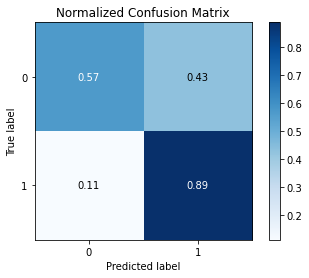

In [22]:
# Classification Report
print(classification_report(y_test, y_pred, digits=2))

# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

# plotar matriz de confusão
plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

**Resultado final**

Acima, podemos ver na tabela de classificação, que alcançamos um recall de aproximadamente 89% com os dados de treino.

Por que dei tanta ênfase ao recall e não a outras medidas de nota para o modelo?
Simples, é o recall que que mede o número de acertos de churn sobre todos os churn, ou seja, um recall baixo significa uma alta evasão que o modelo não preveu. E é exatamente isso que queremos, um modelo que prevê evasões de clientes.

## Conclusões

Os dados de testes não haviam sido passados para o modelo ainda. No entanto, ele manteve um desempenho próximo àquele estimado anteriormente, graças a um bom trabalho de otimização nos parâmetros.

Ainda há espaço para se tentar outras técnicas de balanceamento de dados e também técnicas de machine learning como feature engineering e feature selection.

Espero que tenham gostado do projeto!